## This notebook loads and describes results from the top model

### Load in the needed modules and dependencies

In [1]:
import os
import fsspec, json
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

## Load in local functions
import sys
sys.path.append('/content')
from src.utils import plot_obs_predict

### First, load in credentials and create a file system that will allow access to Azure Blob storage

In [2]:
# reads the credential file
with open('/content/credentials') as credentials:
    f = credentials.readlines() #gets the individual lines
    
# now assign those values to os.environ as accessible variables
for var in f:
    key, value = var.split(' = ') 
    #be sure the ' = 'has a space before and after in the credentials file
    os.environ[key] = value.rstrip('\n')

# then we will store our keys into a variable called storage_options
storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY'],
                 'connection_string': os.environ['CONNECTION_STRING']}

fs = fsspec.filesystem('az',\
                       account_name=storage_options['account_name'],\
                       account_key=storage_options['account_key'])   


### Load in the top model from Azure Blob storage based on analysis-wide parameters:

In [3]:
cloud_thr = 80
buffer_distance = 500
mm1 = "lulc"
mm2 = "mndwi"
n_folds = 5
seed = 123

# The path to the top model is dynamically determined based on the above 
# parameters
model_fn = f"model-output/top_model_buffer{buffer_distance}m_daytol8_" + \
    f"cloudthr{cloud_thr}percent_{mm1}{mm2}_masking_{n_folds}folds_" + \
    f"seed{seed}_metadata.json"

with fs.open(model_fn) as f:
    top_model = json.load(f)

### Let's take a look at the parameters for the top model:

In [4]:
features = top_model["features"]

print(f"The top model has the following features: \n \
    {features} \n")

print(f"Here is information on the various hyperparameters of the model: \n \
    Layer architecture: {top_model['layer_out_neurons']} \n \
    Number of training epochs: {top_model['epochs']} \n \
    Learning rate: {top_model['learning_rate']} \n \
    Batch size: {top_model['batch_size']} \n \
    Activation layer: {top_model['activation']} \n \
    Weight decay: {top_model['weight_decay']}")

The top model has the following features: 
     ['sentinel-2-l2a_B02', 'sentinel-2-l2a_B03', 'sentinel-2-l2a_B04', 'sentinel-2-l2a_B08', 'sentinel-2-l2a_B07', 'sentinel-2-l2a_B8A', 'sentinel-2-l2a_B05', 'sentinel-2-l2a_B06', 'is_brazil'] 

Here is information on the various hyperparameters of the model: 
     Layer architecture: [4, 4, 2] 
     Number of training epochs: 15000 
     Learning rate: 0.0005 
     Batch size: 16 
     Activation layer: PReLU(num_parameters=1) 
     Weight decay: 0.01


### Now, let's plot the loss curves for the training set:

Note that there is no loss curve for a validation set because we used a 
cross-validation approach for model selection.

Text(0, 0.5, 'Loss (MSE, log scale)')

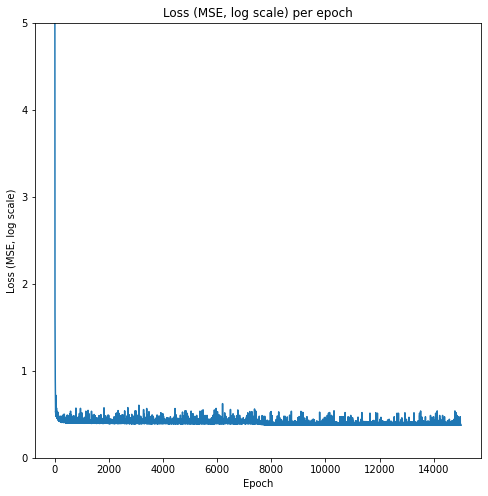

In [5]:
loss = top_model["train_loss"]

plt.figure(figsize=(8,8))
ax = plt.gca()
ax.set_ylim([0,5])
plt.plot(loss, )
plt.title("Loss (MSE, log scale) per epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE, log scale)")

### Now, the moment of truth. Let's plot the one-to-one plot and check out the R-squared:

R-squared: 0.722259589280074


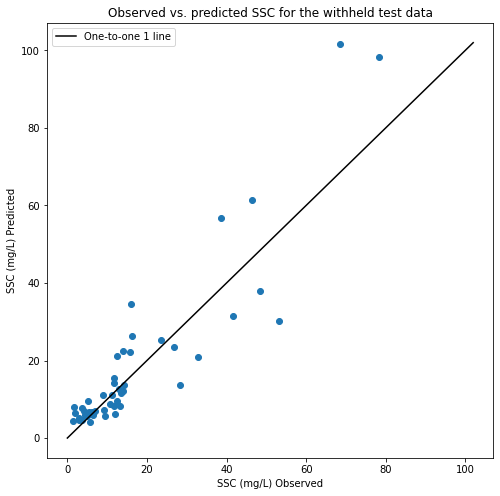

In [6]:
## We'll borrow our existing function, plot_obs_predict, found in utils.py

# Pull the observed and predicted values for the test set from the top model
# These observations are on the log scale, so we'll need to convert them
# back to the native scale prior to plotting
obs_pred = pd.DataFrame({
    "pred": [np.exp(x) for x in top_model["y_pred_test"]],
    "obs": [np.exp(x) for x in top_model["y_obs_test"]]
})

title = "Observed vs. predicted SSC for the withheld test data"

print(f"R-squared: {r2_score(obs_pred['obs'], obs_pred['pred'])}")
plot_obs_predict(obs_pred, units="SSC (mg/L)", title=title)